# Data Transformation by Attribute Normalization — Min–Max Normalization

> This notebook is a hands‑on demo that accompanies the slide **‘Data Transformation by Attribute Normalization — Min–Max Normalization’**.

**What you will learn**
- What Min–Max normalization is and why we use it
- The formula and how to apply it by hand
- How to use `scikit‑learn`'s `MinMaxScaler`
- How outliers affect Min–Max scaling
- How to choose a target range and reverse the transform (`inverse_transform`)
- Common pitfalls and quick checks


## 0. Setup (packages)
If you are running this in VS Code for the first time, run the cell below to install the dependencies. If they are already installed, it will be quick.

In [ ]:
#%python -m venv venv
#%./venv/scripts/activate
#%pip -q install numpy pandas matplotlib seaborn scikit-learn

## 1. Imports & Reproducibility

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

np.random.seed(42)
sns.set_context('notebook')
plt.rcParams['figure.figsize'] = (8, 4)

## 2. Concept — What is Min–Max Normalization?
Min–Max normalization rescales a numeric feature so that **all values land within a chosen interval** (commonly `[0, 1]`).

**Formula (for range [0, 1]):**\
$x' = \frac{x - x_{\min}}{x_{\max} - x_{\min}}$

**General Formula (for range [a, b]):**\
$x' = a + \frac{(x - x_{\min})(b - a)}{x_{\max} - x_{\min}}$

Intuition: we ask *‘how far is x between the smallest and largest observed values?’*


## 3. By‑hand example from the class notes
Suppose the **Income** attribute has: `min = 12,000`, `max = 98,000`, and we want to normalize `x = 73,600` into `[0, 1]`.

We compute: $x' = (73,600 - 12,000) / (98,000 - 12,000)$.


In [3]:
xmin, xmax = 12000, 98000
x = 73600
x_prime = (x - xmin) / (xmax - xmin)
x_prime

0.7162790697674418

**Interpretation:** the result tells us where `73,600` sits **between** the minimum and maximum incomes.

## 4. Small synthetic dataset (to visualize)
We'll make a toy dataset with an `income` feature and see how Min–Max scaling changes it.

In [4]:
# Create a skewed income distribution (in dollars)
income = np.concatenate([
    np.random.normal(60000, 8000, size=180),
    np.random.normal(90000, 5000, size=15)  # a few higher earners
])
income = np.clip(income, 20000, 120000)
df = pd.DataFrame({
    'income': income.astype(int)
})
df.head()

,income
0,63973
1,58893
2,65181
3,72184
4,58126


### Plot: before scaling

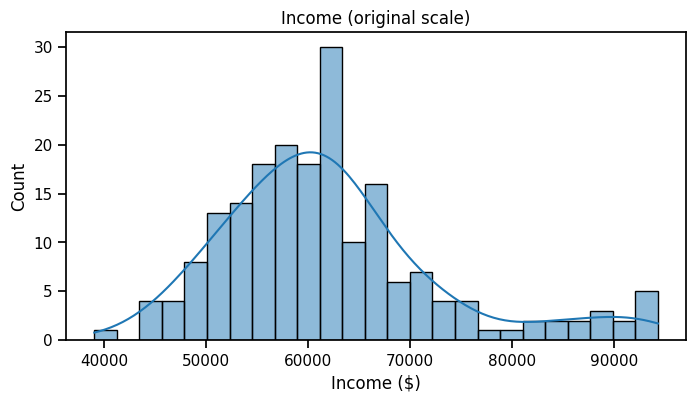

In [5]:
fig, ax = plt.subplots()
sns.histplot(df['income'], bins=25, kde=True, ax=ax)
ax.set_title('Income (original scale)')
ax.set_xlabel('Income ($)')
plt.show()

## 5. Apply Min–Max scaling with `scikit‑learn`

In [6]:
scaler_01 = MinMaxScaler(feature_range=(0, 1))
scaled = scaler_01.fit_transform(df[['income']])
df['income_scaled_0_1'] = scaled
df[['income', 'income_scaled_0_1']].head()

,income,income_scaled_0_1
0,63973,0.451330
1,58893,0.359366
2,65181,0.473198
3,72184,0.599975
4,58126,0.345481


### Plot: after scaling to [0, 1]

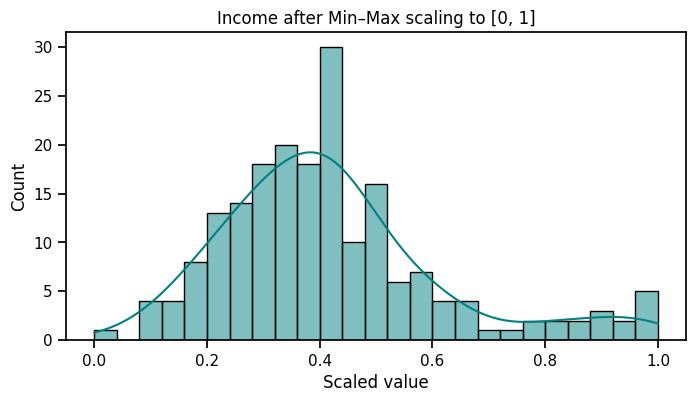

In [7]:
fig, ax = plt.subplots()
sns.histplot(df['income_scaled_0_1'], bins=25, kde=True, ax=ax, color='teal')
ax.set_title('Income after Min–Max scaling to [0, 1]')
ax.set_xlabel('Scaled value')
plt.show()

## 6. Change the target range (e.g., [-1, 1])
Changing the feature range can be useful when an algorithm expects inputs centered around zero.

In [8]:
scaler_m11 = MinMaxScaler(feature_range=(-1, 1))
df['income_scaled_-1_1'] = scaler_m11.fit_transform(df[['income']])
df[['income', 'income_scaled_-1_1']].head()

,income,income_scaled_-1_1
0,63973,-0.097341
1,58893,-0.281269
2,65181,-0.053603
3,72184,0.199949
4,58126,-0.309039


## 7. Inverse transform (get back to original units)
After training a model on scaled data, you might want to **map predictions back** to dollars.

In [9]:
# Take a few scaled values and recover dollars
sample_scaled = np.array([[0.10], [0.50], [0.90]])
recovered = scaler_01.inverse_transform(sample_scaled)
pd.DataFrame({
    'scaled': sample_scaled.flatten(),
    'recovered_$': recovered.flatten().round(2)
})

,scaled,recovered_$
0,0.1,44565.9
1,0.5,66661.5
2,0.9,88757.1


## 8. Sensitivity to outliers (important caveat)
Min–Max uses $x_{\min}$ and $x_{\max}$, so an **extreme outlier** can squeeze most values into a small portion of the [a, b] range.

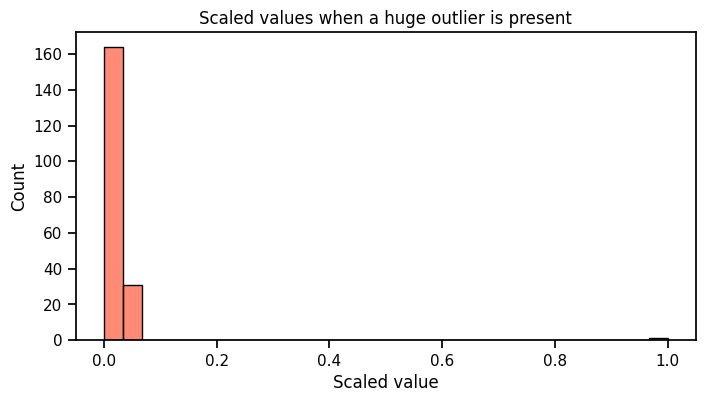

,income,income_scaled_0_1,income_scaled_-1_1,income_scaled_with_outlier
191,94281,1.000000,1.000000,0.057483
192,91070,0.941871,0.883742,0.054142
193,83771,0.809736,0.619472,0.046546
194,90865,0.938160,0.876319,0.053928
195,1000000,NaN,NaN,1.000000


In [10]:
df_out = df.copy()
# Introduce a single extreme value (e.g., a data error or rare case)
df_out.loc[len(df_out)] = {
    'income': 1_000_000,
    'income_scaled_0_1': np.nan,
    'income_scaled_-1_1': np.nan,
}

scaler_out = MinMaxScaler()
df_out['income_scaled_with_outlier'] = scaler_out.fit_transform(df_out[['income']])

fig, ax = plt.subplots()
sns.histplot(df_out['income_scaled_with_outlier'], bins=30, ax=ax, color='tomato')
ax.set_title('Scaled values when a huge outlier is present')
ax.set_xlabel('Scaled value')
plt.show()

df_out.tail()  # last few rows showing the outlier

**Takeaway:** if outliers are present, consider removing/adjusting them first, or use a method less sensitive to outliers (e.g., robust scaling).

## 9. Edge cases & quick checks
- If a feature is **constant** (all values equal), then $x_{\max} - x_{\min} = 0$. Most libraries map all outputs to the lower bound (e.g., 0).
- Always store the **fitted scaler** (using `fit` on the **training** split) and reuse it to transform the validation/test data to avoid leakage.
- Keep the **target range** consistent across training and inference.

In [11]:
# Demonstrate constant-feature behavior
const = np.array([[5], [5], [5]], dtype=float)
sc = MinMaxScaler()
const_scaled = sc.fit_transform(const)
const_scaled  # all zeros because min == max

array([[0.],
       [0.],
       [0.]])

## 10. Practice exercises (for students)
1. Change the target range to `[2, 3]` and rescale `df['income']`. What changes do you notice?
2. Add a second outlier at `-10,000` (if your domain allowed negatives) and note the effect.
3. Create a small function `minmax_scale(x, a, b)` that implements the **general** formula and test it.
4. Using `inverse_transform`, recover the original scale for `scaled = [0.25, 0.5, 0.75]`.
5. (Challenge) Compare Min–Max to Z‑score standardization on the same data using histograms.

---
_Last updated: 2026-02-13 11:32:19 UTC_
